# SIMPLE K-Nearest Neighbours for Tiny Images - Raw Pixels as Features

## Initial Setup

In [11]:
from __future__ import division
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

import imageutils

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Tiny Images into a Matrix 

In [17]:
base_dir = 'tiny_images_32'
(X_all, y_all, classes, class_dict) = imageutils.load_data(base_dir)
image_height = X_all.shape[1]
image_width = X_all.shape[2]
print(X_all.shape)
print(classes)

(1360, 32, 32, 3)
['bluebell', 'buttercup', 'colts_foot', 'cowslip', 'crocus', 'daffodil', 'daisy', 'dandelion', 'fritillary', 'iris', 'lily_valley', 'pansy', 'snowdrop', 'sunflower', 'tigerlily', 'tulip', 'windflower']


## Reshape the matrix so that each row is an entire image

In [18]:
# Flatten the data so that each row in X_all_rows represents an image
X_all_rows = np.reshape(X_all, (X_all.shape[0], -1))
print(X_all_rows.shape)

(1360, 3072)


## Randomly Shuffle the Images

In [26]:
# Randomly shuffle the input images and labels (IN THE SAME RANDOM ORDER SO THEY ARE STILL CORRELATED)
rng_state = np.random.get_state()
np.random.shuffle(X_all_rows)
np.random.set_state(rng_state)
np.random.shuffle(y_all)

## Plot example images from each class

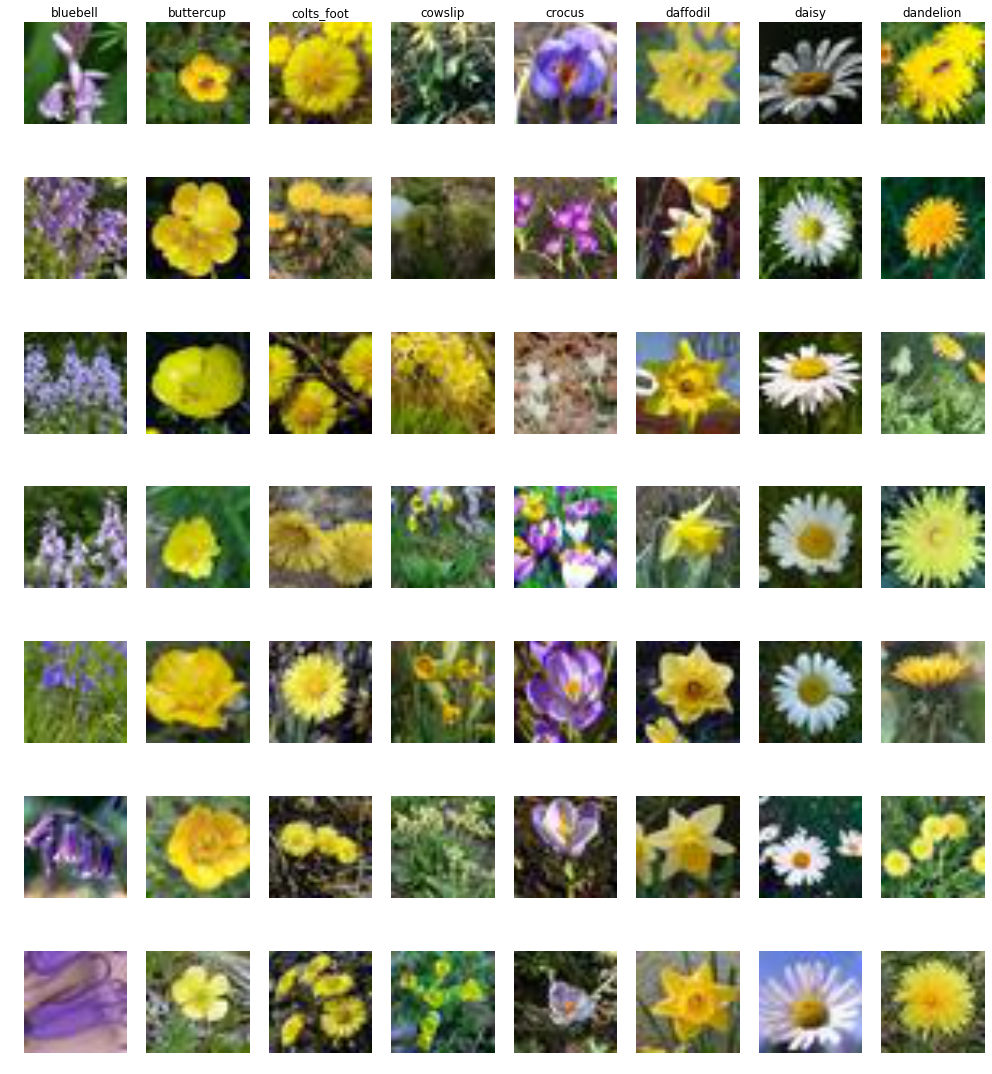

In [19]:
num_classes = 8
samples_per_class = 7
plt.figure(figsize=(1.7 * num_classes, 2.3 * samples_per_class))
plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.9, hspace=0.35)
for y, class_name in enumerate(classes[:num_classes]):
    indexes = np.flatnonzero(y_all == y)
    indexes = np.random.choice(indexes, samples_per_class, replace=False)
    for i, index in enumerate(indexes):
        plt_index = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_index)
        plt.imshow(X_all[index].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(class_name)
plt.show()

## Plot a Gallery of Flowers

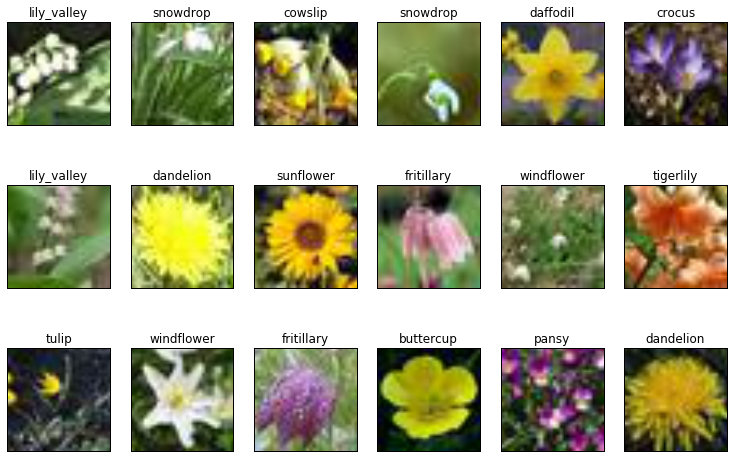

In [30]:
def plot_gallery(images, labels, w, h, n_row=3, n_col=6):
    """Plot a gallery of flowers"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.9, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(images[i].reshape((h,w,3)).astype('uint8'))
        plt.title(classes[labels[i]], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_all_rows, y_all, image_width, image_height)

## Split data into train/test segments

In [20]:
# Split the data into train and test segments
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all_rows, y_all, test_size=0.25)

## Run K-Nearest-Neighbour Classifier from scikit-learn

In [24]:
from sklearn.neighbors import KNeighborsClassifier

# This does 1-nearest-neighbour with L1 distance
clf = KNeighborsClassifier(n_neighbors=1, p=1, weights='uniform')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print("accuracy: {0}".format(accuracy))

accuracy: 0.397058823529


## Plot a Confusion Matrix to Show Performance of KNN

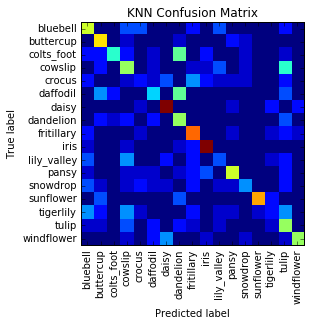

In [27]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
plt.imshow(confusion, interpolation='nearest')

tick_marks = np.arange(len(classes))
plt.title('KNN Confusion Matrix')
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')

## Perform Cross-Validation on the Value of K _and_ the Type of Distance

We want to search for the best combination of K (= 1, 3, 5, ...) and the distance measure (L1, L2, with uniform weights or distance-based weights).

In [25]:
from collections import defaultdict

k_options = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
num_folds = 10

num_rows = X_train.shape[0]
print("Num examples = {0}".format(num_rows))
rows_per_fold = num_rows / num_folds

k_accuracies = defaultdict(list)

for k in k_options:
    print("Working on k={0}".format(k))
    for fold in range(num_folds):
        classifier = KNeighborsClassifier(n_neighbors=k, p=2, weights='distance')
        
        from_row = int(fold * rows_per_fold)
        to_row = int(fold * rows_per_fold + rows_per_fold)
        
        X_validation = np.delete(X_train, range(from_row,to_row), 0)
        y_validation = np.delete(y_train, range(from_row,to_row), 0)
        
        X_validation_test = X_train[from_row:to_row]
        y_validation_test = y_train[from_row:to_row]
        
        classifier.fit(X_validation, y_validation)
        y_validation_pred = classifier.predict(X_validation_test)
        
        fold_accuracy = np.mean(y_validation_pred == y_validation_test)
        k_accuracies[k].append(fold_accuracy)

Num examples = 1020
Working on k=1
Working on k=3
Working on k=5
Working on k=7


KeyboardInterrupt: 

In [30]:
for k in sorted(k_accuracies):
    for accuracy in k_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.362745
k = 1, accuracy = 0.382353
k = 1, accuracy = 0.372549
k = 1, accuracy = 0.323529
k = 1, accuracy = 0.382353
k = 1, accuracy = 0.343137
k = 1, accuracy = 0.480392
k = 1, accuracy = 0.362745
k = 1, accuracy = 0.362745
k = 1, accuracy = 0.323529
k = 3, accuracy = 0.323529
k = 3, accuracy = 0.401961
k = 3, accuracy = 0.333333
k = 3, accuracy = 0.303922
k = 3, accuracy = 0.392157
k = 3, accuracy = 0.343137
k = 3, accuracy = 0.519608
k = 3, accuracy = 0.382353
k = 3, accuracy = 0.362745
k = 3, accuracy = 0.382353
k = 5, accuracy = 0.352941
k = 5, accuracy = 0.392157
k = 5, accuracy = 0.343137
k = 5, accuracy = 0.313725
k = 5, accuracy = 0.392157
k = 5, accuracy = 0.333333
k = 5, accuracy = 0.441176
k = 5, accuracy = 0.421569
k = 5, accuracy = 0.333333
k = 5, accuracy = 0.372549
k = 7, accuracy = 0.372549
k = 7, accuracy = 0.362745
k = 7, accuracy = 0.362745
k = 7, accuracy = 0.313725
k = 7, accuracy = 0.362745
k = 7, accuracy = 0.323529
k = 7, accuracy = 0.460784
k

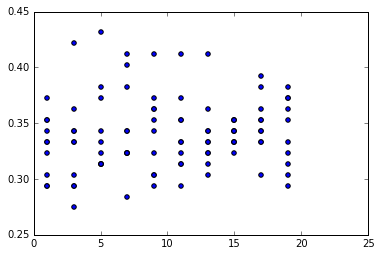

In [37]:
for k in k_options:
  accuracies = k_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

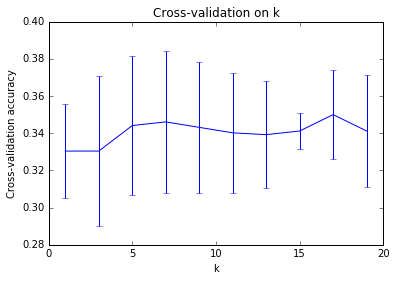

In [38]:
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_accuracies.items())])
plt.errorbar(k_options, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

From the results above, we retrain the classifier using all the training data with the best value of k.

In [43]:
classifier = KNeighborsClassifier(n_neighbors=1, p=1, weights='uniform')

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

final_accuracy = np.mean(y_pred == y_test)

print("Final accuracy on the test set = {0}".format(final_accuracy))

Final accuracy on the test set = 0.385294117647


# Trying Out Principal Component Analysis (PCA)

PCA is an unsupervised technique to reduce the dimensionality of the input data.
* Can use Randomized PCA or regular PCA

In [28]:
from sklearn.decomposition import PCA

n_components = 150

print "Extracting the top %d eigenflowers from %d flowers" % (n_components, X_train.shape[0])

pca = PCA(n_components=n_components, whiten=True) # Don't know about whiten

%time pca.fit(X_train)

print(pca.components_.shape)
eigenflowers = pca.components_

print(eigenflowers[0])

eigenflower_titles = ["eigenflower %d" % i for i in range(eigenflowers.shape[0])]
plot_gallery(eigenflowers, [0] * 150, 32, 32)

Extracting the top 150 eigenflowers from 1020 flowers
CPU times: user 5.05 s, sys: 254 ms, total: 5.31 s
Wall time: 2.5 s
(150, 3072)
[-0.02072159 -0.02047663 -0.02229609 ..., -0.01600547 -0.01556085
 -0.01467407]


NameError: name 'plot_gallery' is not defined